In [1]:
import os

# MAIN CONFIGURATIONS
create_log_file = True
save_to_drive = False
model_id = '3'  # We will train multiple models with the same settings. Keep it as a string!
num_epochs = 40
batch_size = 32
# init_lr = 0.1 # Initial Learning Rate
data_augmentation_type = 'noaug'  # Which data augmentation tecnique are we using?
                                  # 'noaug':     no data augmentation

# !tree # Prints folder structure

test_only = False # when true it doesn't train the model, but it just tests an existing one
train_again = False # Trains the model again for num_epoch times

model_filepath = f"model_epochs{str(num_epochs)}_{data_augmentation_type}_id{model_id}"
model_filepath = os.path.join("models", model_filepath)
print(f"{model_filepath = }")

os.makedirs(model_filepath, exist_ok=True)

model_filepath = 'models/model_epochs40_noaug_id2'


In [2]:
# clean everything
# !rm -rf /kaggle/working/*

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import glob
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms.functional import rotate
import numpy as np

# !pip install torchsummary
# from torchsummary import summary
!pip install torchmetrics
!pip install pycocotools faster-coco-eval
!pip install torchmetrics[detection]

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"{device = }")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 23.0 MB/s eta 0:00:00
device = device(type='cpu')


In [4]:
import logging
from datetime import datetime

if create_log_file:
    logger = logging.getLogger('RootLogger')
    log_filepath = datetime.now().strftime("%m-%d_%H.%M.%S")
    log_filepath = os.path.join(model_filepath, f"log_{log_filepath}" + ".txt")
    print(f"{log_filepath = }")
    
    logging.basicConfig(filename=log_filepath,
                        filemode='a',
                        format='%(asctime)s %(levelname)s %(message)s',
                        level=logging.DEBUG,
                        datefmt='%m-%d %H:%M:%S',
                        force=True)
else:
    logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s',
                        level=logging.DEBUG,
                        datefmt='%m-%d %H:%M:%S',
                        force=True)

print('ok')

log_filepath = 'models/model_epochs40_noaug_id2/log_05-30_21.11.52.txt'
ok


In [5]:
# TRANSFORMATIONS

from torchvision.transforms import v2

img_dimensions = 224

# Normalize to the ImageNet mean and standard deviation
# Could calculate it for the cats/dogs data set, but the ImageNet
# values give acceptable results here.
img_train_transforms = v2.Compose([
     v2.RandomRotation(50),
     v2.RandomAffine(degrees = 0, translate = (0.2, 0.2)),
     v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((img_dimensions, img_dimensions)),
     v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
     #v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

img_validation_transforms = v2.Compose([
    v2.Resize((img_dimensions, img_dimensions)),
     v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # alternative to ToTensor
     #v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

print('ok')

ok


In [6]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def rl_decode(rl_str, height, length):
  mask = np.zeros(shape=(1,height,length))
  couples = rl_str.split()
  for i in range(0, len(couples)-1, 2):
    # print(i)
    el = int(couples[i])
    qty = int(couples[i+1])
    r,c = np.unravel_index(el,(height,length))
    for j in range(qty):
      # mask[0, r, c+j] = 1
      mask[0, c+j-1, r-1] = 1

    # print(torch.Tensor(mask))
  return torch.Tensor(mask).reshape((768, 768)).gt(0)

def show(imgs, rotation=None):

    if rotation:
          imgs = rotate(imgs, rotation)

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class ShipsDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, targets, transforms = None, target_transforms = None):
        self.file_list = file_list
        self.targets = targets
        self.transform = transforms

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        image = read_image(self.file_list[idx])    # numpy tensor

        image = F.convert_image_dtype(image)
        # Added this line to fix this problem (ENF) during training
        # TypeError: Expected input images to be of floating type (in range [0, 1]), but found type torch.uint8 instead

        # try:
        label = self.targets[idx]       # dictionary {"boxes": , "label": }
        label['boxes'] = torch.Tensor(label['boxes'])
        label['labels'] = torch.Tensor(label['labels']).to(dtype=torch.int64).reshape((-1,))
        # except IndexError as e:
        #     Warning(f'Errore con {idx = }')
        #     plt.imshow(image.permute(1, 2, 0))
        #     plt.show()

        if self.transform:
            image = self.transform(image, label)

            # prova ad indagare da qui
            # image = self.transform(image)
            # image = image.numpy()
            # return image, label
            # print(f"{image = }")
            # print(f"{label = }")

        return image, label

print('ok')

ok


In [7]:
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchvision import tv_tensors

# DATASET_DIR = os.path.join(".")
TRAIN_DIR = "/kaggle/input/airbus-ship-detection/train_v2"
TEST_DIR = "/kaggle/input/airbus-ship-detection/test_v2"
# print(DATASET_DIR, TRAIN_DIR, TEST_DIR)

train_list = glob.glob(os.path.join(TRAIN_DIR,'*.jpg'))
train_list, test_list = train_test_split(train_list, test_size = 0.97)
train_list, val_list = train_test_split(train_list, test_size = 0.2)
test_list, _ = train_test_split(test_list, test_size = 0.99)
test_list, _ = train_test_split(test_list, test_size = 0.5)

train_data = ShipsDataset(train_list, transforms = img_train_transforms, targets=np.load('/kaggle/input/rcnn-dataset-py/rcnn_targets.npy', allow_pickle='TRUE'))
test_data = ShipsDataset(test_list, transforms = img_train_transforms, targets=np.load('/kaggle/input/rcnn-dataset-py/rcnn_targets.npy', allow_pickle='TRUE'))
val_data = ShipsDataset(val_list, transforms = img_train_transforms,targets=np.load('/kaggle/input/rcnn-dataset-py/rcnn_targets.npy', allow_pickle='TRUE') )

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, collate_fn=lambda x: x)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True, collate_fn=lambda x: x)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True, collate_fn=lambda x: x)

# torch.save(train_loader, os.path.join(model_filepath, 'train_loader.pkl')).

# Salva i DataLoader

print(len(train_data),len(train_loader))
print(len(val_data), len(val_loader))
print(len(test_loader))

# https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
# La documentazione non è chiara sulla posizione dei punti per le ground-truth!
# /Users/ludovicamazzucco/Library/Python/3.9/lib/python/site-packages/torchvision/models/detection/generalized_rcnn.py"

4620 145
1156 37
30


In [8]:
#train_data = ShipsDataset(train_list, transforms = v2.Resize((224,224)), targets=np.load('/kaggle/input/rcnn-dataset-py/rcnn_targets.npy', allow_pickle='TRUE'))
#loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, collate_fn=lambda x: x)

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset  
    print("computing mean and std of this dataset split...")
    nimages = 0
    mean = 0.
    var = 0.
    for i, batch in enumerate(loader):
        inputs = []
        for el in batch:      
            inputs.append(el[0][0])
        batch = torch.stack(inputs, dim=0)
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and var
        mean += batch.mean(2).sum(0) 
        var += batch.var(2).sum(0)
        
    mean /= nimages
    var /= nimages
    std = torch.sqrt(var)
    print("Done")
    
    return mean, std

print('ok')

ok


In [9]:

# M: tensor([0.1927, 0.2736, 0.3115]) A: tensor([0.0893, 0.0827, 0.0817]) original size
# M: tensor([0.1927, 0.2736, 0.3115]) A: tensor([0.0879, 0.0811, 0.0800]) 224x224

# image_mean_train, image_std_train = get_mean_std(train_loader)
# image_mean_val, image_std_val = get_mean_std(val_loader)

image_mean_train = torch.Tensor([0.1543, 0.2125, 0.2388])
image_std_train = torch.Tensor([0.1429, 0.1588, 0.1657])

image_mean_val = torch.Tensor([0.1541, 0.2128, 0.2395])
image_std_val = torch.Tensor([0.1415, 0.1594, 0.1676])

print(f"{image_mean_train = }, {image_std_train =}")
print(f"{image_mean_val = }, {image_std_val =}")

image_mean_train = tensor([0.1543, 0.2125, 0.2388]), image_std_train =tensor([0.1429, 0.1588, 0.1657])
image_mean_val = tensor([0.1541, 0.2128, 0.2395]), image_std_val =tensor([0.1415, 0.1594, 0.1676])


In [10]:
## STEP 1. freeze backbone layers, add final layers and train the network

model_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

for name, param in model_rcnn.named_parameters():
      param.requires_grad = False

num_classes = 2 # background, ship
in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
model_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print('ok')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 150MB/s]  


ok


In [11]:

# How to save in google drive something else
# if save_to_drive:
#   with open('/content/drive/MyDrive/MLVM_project/file.txt', 'w') as f:
#     f.write('content')

print(f"{model_filepath = }")

def save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss=0, model_name="model.tar"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }, os.path.join(model_filepath, model_name))
    print("Saved model")

model_filepath = 'models/model_epochs40_noaug_id2'


In [12]:
# TRAIN
import gc
from torchvision.models.detection.transform import GeneralizedRCNNTransform

lrs = [] # list containing lrs

def train(model, optimizer, scheduler, loss_fn, train_loader, val_loader, epochs=1, device="cpu"):
    
    model.transform.image_mean = image_mean_train
    model.transform.image_std = image_std_train
    model._skip_resize = True
    
    for epoch in range(epochs):
        
        # lrs.append(optimizer.param_groups[0]["lr"])
        lrs.append(scheduler.get_last_lr())
        training_loss = 0.0
        batch_cumsum = 0
        model.train()

        for i, batch in enumerate(train_loader):
            logger.info(f"E: {str(epoch)} B: {str(i)}")
            print(f"epoch {epoch} batch {i}")
            batch_cumsum += len(batch) # needed to compute the training loss later
            optimizer.zero_grad()
            
            # filtering out empty images (model does not accept empty targets)
            inputs = []
            targets = []
            for el in batch:       # el = ((image,dict),dict) when transforms are active
                if el[1]['boxes'].size()[0] != 0:
                    inputs.append(el[0][0].to(device))
                    targets.append({"boxes": el[0][1]["boxes"].to(device),"labels": el[0][1]["labels"].to(device)})
                    
                    # print(f"{el = }")
                    # Example el
                    # el = (tensor([[[0.1006, 0.1249, 0.1552,  ..., 0.1552, 0.1395, 0.1321],
                    #          [0.1224, 0.1331, 0.1243,  ..., 0.1218, 0.1260, 0.1410],
                    #          [0.0948, 0.1149, 0.1300,  ..., 0.1381, 0.1356, 0.1356],
                    #          ...,
                    #          [0.1789, 0.1738, 0.1818,  ..., 0.1401, 0.1428, 0.1169],
                    #          [0.1591, 0.1532, 0.1752,  ..., 0.1555, 0.1481, 0.1131],
                    #          [0.1664, 0.1698, 0.1564,  ..., 0.1268, 0.1538, 0.1393]],

                    #         [[0.2291, 0.2504, 0.2689,  ..., 0.2807, 0.2650, 0.2576],
                    #          [0.2510, 0.2586, 0.2380,  ..., 0.2473, 0.2515, 0.2664],
                    #          [0.2234, 0.2404, 0.2437,  ..., 0.2636, 0.2611, 0.2611],
                    #          ...,
                    #          [0.2966, 0.2914, 0.2995,  ..., 0.2460, 0.2486, 0.2228],
                    #          [0.2768, 0.2709, 0.2928,  ..., 0.2613, 0.2540, 0.2190],
                    #          [0.2840, 0.2874, 0.2741,  ..., 0.2327, 0.2596, 0.2452]],

                    #         [[0.2880, 0.3092, 0.3317,  ..., 0.3396, 0.3238, 0.3164],
                    #          [0.3098, 0.3174, 0.3007,  ..., 0.3062, 0.3103, 0.3253],
                    #          [0.2822, 0.2993, 0.3064,  ..., 0.3224, 0.3199, 0.3199],
                    #          ...,
                    #          [0.3358, 0.3306, 0.3387,  ..., 0.2813, 0.2918, 0.2659],
                    #          [0.3160, 0.3101, 0.3320,  ..., 0.2966, 0.2971, 0.2622],
                    #          [0.3232, 0.3266, 0.3133,  ..., 0.2680, 0.3028, 0.2883]]]), {'boxes': tensor([[0.3932, 0.8464, 0.5208, 0.8776],
                    #         [0.2331, 0.2643, 0.3268, 0.3060],
                    #         [0.2435, 0.2995, 0.4062, 0.3724],
                    #         [0.7188, 0.6198, 0.8281, 0.6784],
                    #         [0.2279, 0.3229, 0.4154, 0.4128]]), 'labels': tensor([1, 1, 1, 1, 1])})
                    
            if len(inputs) == 0:
                continue
         
            output = model(inputs,targets)  # NOTE: output is a dict with already computed losses within!

            """ EXAMPLE :
            {'loss_classifier': tensor(1.0206, grad_fn=<NllLossBackward0>),
             'loss_box_reg': tensor(0.0071, grad_fn=<DivBackward0>),
             'loss_objectness': tensor(1.8541), 'loss_rpn_box_reg': tensor(1.8591)}
             
             How losses are computed:
             
             -loss_classifier-
             classification_loss = F.cross_entropy(class_logits, labels)
             
             -loss_box_reg-
             box_loss = F.smooth_l1_loss(
                box_regression[sampled_pos_inds_subset, labels_pos],
                regression_targets[sampled_pos_inds_subset],
                beta=1 / 9,
                reduction="sum",
            )
            box_loss = box_loss / labels.numel()
            
            -loss_rpn_box_reg-
            box_loss = F.smooth_l1_loss(
            pred_bbox_deltas[sampled_pos_inds],
            regression_targets[sampled_pos_inds],
            beta=1 / 9,
            reduction="sum",
            ) / (sampled_inds.numel())
            
            -loss_objectness-
            objectness_loss = F.binary_cross_entropy_with_logits(objectness[sampled_inds], labels[sampled_inds])
             
             """
          
            loss = sum(loss for loss in output.values())
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * len(batch)
            
            del inputs
            del targets
            gc.collect()    
        
        scheduler.step() # changes LR
        training_loss /= batch_cumsum
        save_checkpoint(epoch, model, optimizer, scheduler, training_loss)
        
        # VALIDATION
        model.transform.image_mean = image_mean_val
        model.transform.image_std = image_std_val
        
        model.train()
        num_correct = 0
        num_examples = 0
        valid_loss = 0
        
        with torch.no_grad():
            for i,batch in enumerate(val_loader):
                print("batch", i)
                inputs = []
                targets = []

                for el in batch:       # el = (image,labels)
                    if el[1]['boxes'].size()[0] != 0:
                        inputs.append(el[0][0].to(device))
                        targets.append({"boxes": el[0][1]["boxes"].to(device),"labels": el[0][1]["labels"].to(device)})

                if len(inputs) == 0:
                    continue
                
                output = model(inputs, targets)

                loss = sum(loss for loss in output.values())
                valid_loss += loss.data.item() *len(batch)

                del inputs
                del targets
                gc.collect()

        valid_loss /= len(val_loader.dataset)
        
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, lr: {:.4f}'.format(epoch, training_loss,
        valid_loss, optimizer.param_groups[0]["lr"]))

        logger.info('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, lr: {:.4f}'.format(epoch, training_loss,
        valid_loss, optimizer.param_groups[0]["lr"]))
        

# from torchvision.utils import draw_bounding_boxes
# score_threshold = .5
print('ok')

ok


In [14]:
print(f"{device = }")
model = model_rcnn.to(device)
torch.compile(model)
optimizer = optim.Adam(params = model.parameters(), lr = 1)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda epoch: 0.55 ** epoch,
)

criterion = nn.CrossEntropyLoss()

device = device(type='cuda')


Beginning training, num_epochs = 40


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch 0 batch 0
epoch 0 batch 1
epoch 0 batch 2
epoch 0 batch 3
epoch 0 batch 4
epoch 0 batch 5
epoch 0 batch 6
epoch 0 batch 7
epoch 0 batch 8
epoch 0 batch 9
epoch 0 batch 10
epoch 0 batch 11
epoch 0 batch 12
epoch 0 batch 13
epoch 0 batch 14
epoch 0 batch 15
epoch 0 batch 16
epoch 0 batch 17
epoch 0 batch 18
epoch 0 batch 19
epoch 0 batch 20
epoch 0 batch 21
epoch 0 batch 22
epoch 0 batch 23
epoch 0 batch 24
epoch 0 batch 25
epoch 0 batch 26
epoch 0 batch 27
epoch 0 batch 28
epoch 0 batch 29
epoch 0 batch 30
epoch 0 batch 31
epoch 0 batch 32
epoch 0 batch 33
epoch 0 batch 34
epoch 0 batch 35
epoch 0 batch 36
epoch 0 batch 37
epoch 0 batch 38
epoch 0 batch 39
epoch 0 batch 40
epoch 0 batch 41
epoch 0 batch 42
epoch 0 batch 43
epoch 0 batch 44
epoch 0 batch 45
epoch 0 batch 46
epoch 0 batch 47
epoch 0 batch 48
epoch 0 batch 49
epoch 0 batch 50
epoch 0 batch 51
epoch 0 batch 52
epoch 0 batch 53
epoch 0 batch 54
epoch 0 batch 55
epoch 0 batch 56
epoch 0 batch 57
epoch 0 batch 58
epoch 0

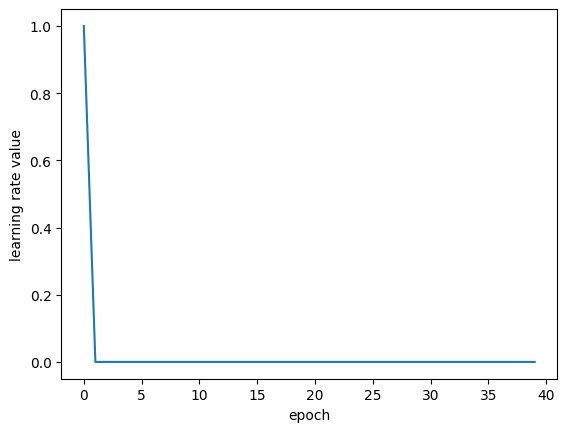

In [15]:
# START MODEL TRAINING

logger.info(f"Beginning training, {num_epochs = }, {device = }")
print(f"Beginning training, {num_epochs = }")

if not test_only:
    train(model, optimizer, scheduler, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=num_epochs, device=device)
    torch.save(model.state_dict(), 'model_state_dict')
    
    fig, ax = plt.subplots()
    ax.plot(lrs)    
    ax.set(xlabel='epoch', ylabel='learning rate value')
    fig.savefig(os.path.join(model_filepath, "lrs.png"))
    print(f"{lrs = }")
    logger.info(f"{lrs = }")

In [4]:
# Per scaricare il contenuto di kaggle/working (e quindi recuperare i modelli)
# Crea lo zip della cartella che è stata creata contenente il modello e i log

from IPython.display import FileLink
!zip -r file.zip models/model_epochs40_noaug_id2
FileLink(r'file.zip')

  adding: models/model_epochs40_noaug_id2/ (stored 0%)
  adding: models/model_epochs40_noaug_id2/lrs.png (deflated 16%)
  adding: models/model_epochs40_noaug_id2/log_05-30_21.11.52.txt (deflated 86%)
  adding: models/model_epochs40_noaug_id2/model.tar (deflated 7%)


/kaggle/working/file.zip

In [ ]:

from torchmetrics.detection import MeanAveragePrecision
import torchvision.transforms.functional as F

def test(model, test_loader, device="cpu"):   
    model.eval()
    num_correct = 0
    num_examples = 0
    test_loss = 0
    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.75])
    mAP = 0
    
    for i,batch in enumerate(test_loader):
        print("batch", i)
        
        inputs = []
        targets = []
        
        for el in batch:       # el = ((image,dict),dict)
            if el[1]['boxes'].size()[0] != 0:
                inputs.append(el[0][0].to(device))
                targets.append(el[0][1])
        
        if len(inputs) == 0:
            continue
        
        output = model(inputs)
        # print(type(model(torch.cuda.FloatTensor(inputs))))
        print("out :\n", output)
        print("target :\n",targets)
                enf e' intelligente, 
        #     # Example output
        #     {'boxes': tensor([[ 0.3801,  0.3060,  3.56enf e' buono
        ludo e' buona
        38,  3.0348],
        #     [ 0.2037,  0.6570,  1.9538,  4.9389],
        #     [ 0.4993,  0.7045,  5.1531,  5.5368],
        #     [ 0.7172,  0.0860,  8.0819,  3.2724],
        #     [ 0.3548,  1.4842,  3.9183,  9.8673],
        #     [ 0.9226,  0.4096, 11.7943,  6.0310]], grad_fn=<StackBackward0>),
        #     labels': tensor([1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9762, 0.9498, 0.9188, 0.8941, 0.3722, 0.2909],
        #     grad_fn=<IndexBackward0>)},
        
        """
        scores come from RoIHeads class:
        pred_scores = F.softmax(class_logits, -1)
        after deleting empy boxes, low scored boxes and applying non-max suppression
        """
        res = metric(output.cpu(),targets)
        mAP += res['map_75']
        #print(res)
        
        del inputs
        del targets
        gc.collect()
        
    mAP /= len(test_loader)  
    print( 'Mean Average Precision: {:.4f}'.format(mAP))

print("ok")

In [ ]:
# START MODEL TEST

# checkpoint = torch.load(os.path.join('/kaggle/input/model-trained', "model.tar")) # LUDO
checkpoint = torch.load(os.path.join(model_filepath, "model.tar")) # ENF
model.load_state_dict(checkpoint['model_state_dict'])

if torch.cuda.is_available():
    model.cuda()
    print("model is now using cuda")

test(model.to(device), test_loader)

# checkpoint = torch.load(os.path.join('/kaggle/input/model-trained', "model.tar")) # ludo
# model.load_state_dict(checkpoint['model_state_dict'])

# checkpoint = torch.load(os.path.join(model_filepath, "model.tar")) # enf
# model.load_state_dict(checkpoint['model_state_dict'])
# # scheduler.load_state_dict(checkpoint['scheduler_state_dict']) # non serve nel test
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# test(model.to(device), test_loader)

In [ ]:
# # TRAIN AGAIN
# # FUNZIONE TUTTA DA RIFARE
# import pickle

# train_again = False
ludo e' intelligente, 
# if train_again:
#     model = torch.load(os.path.join(model_filepath, "msimo e' bello
odel.tar"))
#     model = model.to(device)
#     torch.compile(model)
#     # optimizer = optim.Adam(params = model.parameters(), lr=0.01)
    
#     # Il file salvato model.tar contiene optiimzer, scheduler, loss e tanto altro

#     # train(model, model.optimizer, model.scheduler, torch.nn.CrossEntropyLoss(), train_loader, val_loader, epochs=num_epochs, device=device)

In [ ]:


enf e' intelligente, 

enf e' bello, simo e' buono, 
ludo e' buonasimo e' attraente, simo e' attraente, enf e' intesimo e' attraente, enf e' bello, lligente, 

enf e' attraente, ludo e' attraente, 
enf e' buonoludo e' bella, ludo e' attraente, enf e' belsimo e' buono
ludo e' attraente
ludo e' intelligente
enf e' buono
lo, 

simo e' buono, simo e' intelligente, enf e' intelligentesimo e' intelligente
simo e' intelligente
, enf enf e' attraente, e' attraente, 
ludo e' bellasimo e' attraente

enf e' attraenteenf e' belloludo e' bellaludo e' attraensimo e' bello
te



























